In [1]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
import torch
from matplotlib import pyplot as plt

In [3]:
if torch.cuda.is_available():
    device=torch.device(type='cuda')
else:
    device=torch.device(type='cpu')
print(device)

cuda


In [4]:
train_data=datasets.MNIST(root='/kaggle/temp/mnist_train', train=True, download=True, transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor(),transforms.Normalize([0.5],[0.5])]))

100%|██████████| 9912422/9912422 [04:56<00:00, 33464.30it/s]


Extracting /kaggle/temp/mnist_train/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/temp/mnist_train/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 469887.91it/s]


Extracting /kaggle/temp/mnist_train/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/temp/mnist_train/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4359801.07it/s]


Extracting /kaggle/temp/mnist_train/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/temp/mnist_train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9338494.49it/s]

Extracting /kaggle/temp/mnist_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/temp/mnist_train/MNIST/raw



In [5]:
train_dataloader=DataLoader(dataset=train_data, batch_size=64, shuffle=True)

In [6]:
def convblock(in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.LeakyReLU(0.2))
    return nn.Sequential(*layers)

In [ ]:
def tconvblock(in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    layers=[nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout2d(0.25))
    return nn.Sequential(*layers)

In [7]:
class Generator(nn.Module):
    def __init__(self,latent_dim, img_size):
        super().__init__()
        self.latent_dim=latent_dim
        self.img_size=img_size
        self.init_size=self.img_size//4
        self.lin=nn.Linear(in_features=self.latent_dim,out_features=128*self.init_size*self.init_size )
        self.tconvblocks=nn.Sequential(tconvblock(128,64,4,2,1),tconvblock(64,32,4,2,1))
        self.convtanh=nn.Sequential(nn.Conv2d(32,1,3,1,1),nn.Tanh())
        
    def forward(self,x):
        x=self.lin(x)
        x=x.view(x.shape[0],128,self.init_size,self.init_size)
        x=self.tconvblocks(x)
        x=self.convtanh(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.img_size=img_size
        self.convblocks=nn.Sequential(convblock(1,16,4,2,1), convblock(16,32,4,2,1), convblock(32,64,4,2,1),convblock(64,128,4,2,1))
        self.out=nn.Sequential(nn.Linear(128*(self.img_size//(2**(len(self.convblocks)-1))),2))
        
    def forward(self,x):
        x=self.convblocks(x)
        x=x.view(x.shape[0],-1)
        pred=self.out(x)
        return pred

In [8]:
loss_fn=nn.CrossEntropyLoss().to(device)
n_epochs=20
lr=0.0002

generator=Generator(100,32).to(device)
discriminator=Discriminator(32).to(device)

gopt=optim.Adam(params=generator.parameters(),lr=lr)
dopt=optim.Adam(params=discriminator.parameters(),lr=lr)

In [9]:
def train_one_epoch(plt):
    for i,(imgs,_) in enumerate(train_dataloader):
        noise_vectors=torch.randn((imgs.shape[0],100)).to(device)
        zero_labels=torch.zeros((imgs.shape[0])).to(device).type(torch.int64)
        one_labels=torch.ones((imgs.shape[0])).to(device).type(torch.int64)
        fake_images=generator(noise_vectors)
        pred=discriminator(fake_images)
        gloss=loss_fn(pred,one_labels)
        gopt.zero_grad()
        gloss.backward()
        gopt.step()
        
        real_imgs=imgs.to(device)
        
        pred_on_real=discriminator(real_imgs)
        dloss_on_real=loss_fn(pred_on_real,one_labels)
        pred_on_fake=discriminator(fake_images.detach())
        dloss_on_fake=loss_fn(pred_on_fake,zero_labels)
        dloss=(dloss_on_real+dloss_on_fake)/2
        dopt.zero_grad()
        dloss.backward()
        dopt.step()
        if i%500 == 0:
            print("Batch No.:", i+1,"/",len(train_dataloader),":", "GLoss=",round(gloss.item(),4), "DLoss=",round(dloss.item(),4))
            for j in range(64):
                plt.subplot(8,8,j+1)
                plt.imshow(torch.permute(fake_images[j],(1,2,0)).detach().cpu(),interpolation='nearest', cmap='gray_r')
            plt.show()
            

Epoch 1 / 20 :
Batch No.: 1 / 938 : GLoss= 0.5046 DLoss= 0.7335


/tmp/ipykernel_34/800115703.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8,8,j+1)


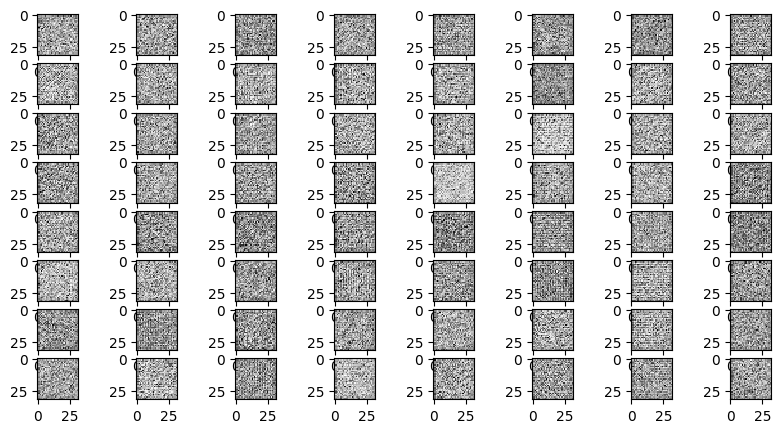

Batch No.: 501 / 938 : GLoss= 3.3505 DLoss= 0.0872


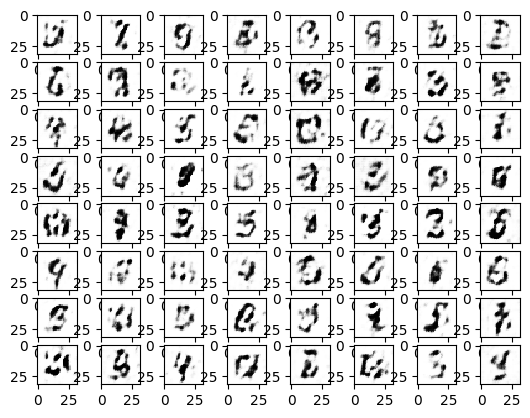

Epoch 2 / 20 :
Batch No.: 1 / 938 : GLoss= 3.4558 DLoss= 0.0379


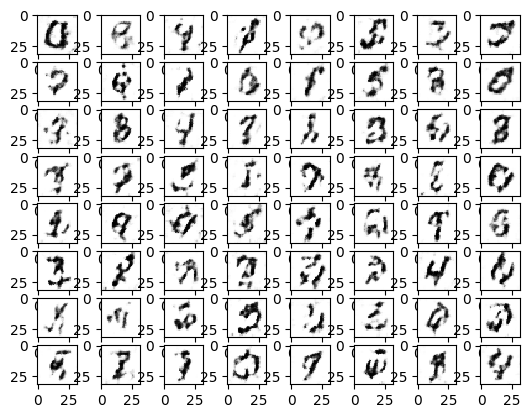

Batch No.: 501 / 938 : GLoss= 6.0657 DLoss= 0.0702


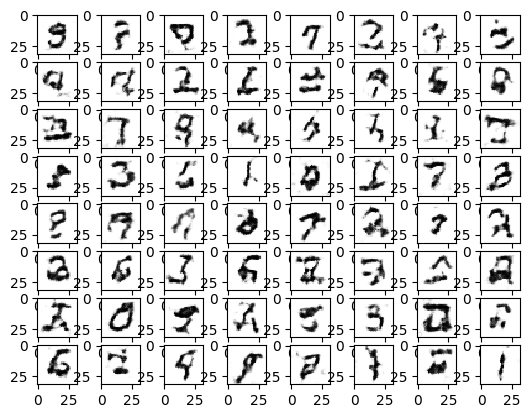

Epoch 3 / 20 :
Batch No.: 1 / 938 : GLoss= 7.4046 DLoss= 0.0119


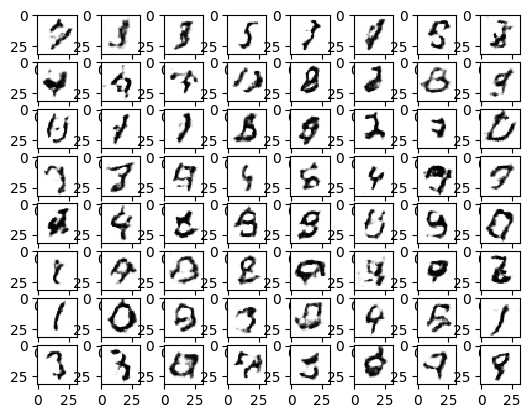

Batch No.: 501 / 938 : GLoss= 2.9803 DLoss= 0.0604


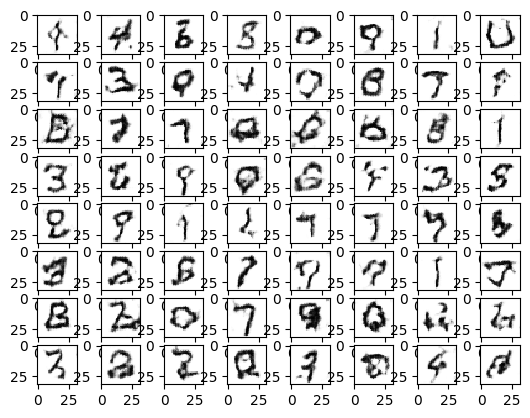

Epoch 4 / 20 :
Batch No.: 1 / 938 : GLoss= 2.5384 DLoss= 0.1138


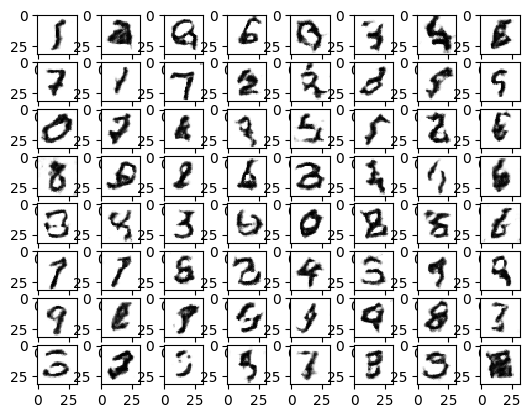

Batch No.: 501 / 938 : GLoss= 7.183 DLoss= 0.0024


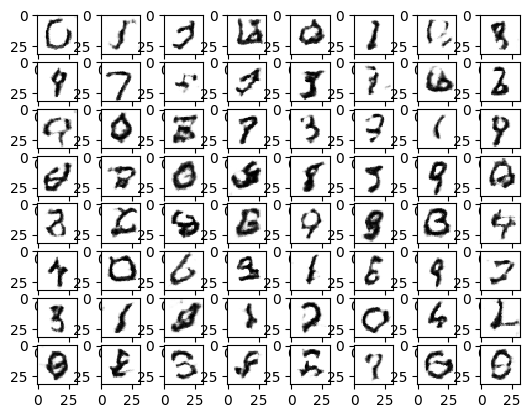

Epoch 5 / 20 :
Batch No.: 1 / 938 : GLoss= 5.5618 DLoss= 0.0375


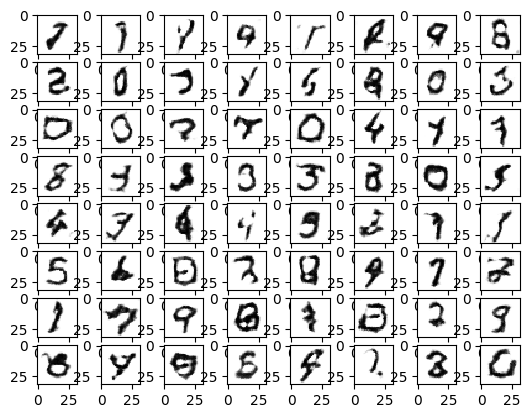

Batch No.: 501 / 938 : GLoss= 7.5186 DLoss= 0.003


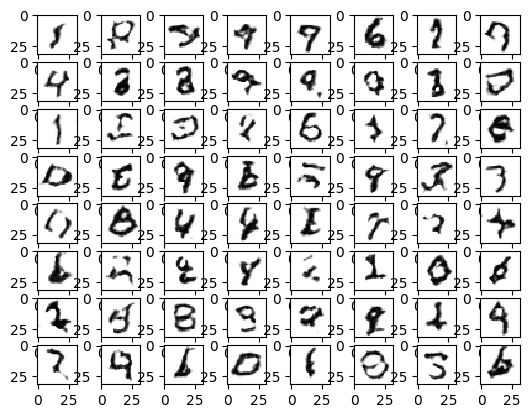

Epoch 6 / 20 :
Batch No.: 1 / 938 : GLoss= 5.6893 DLoss= 0.0133


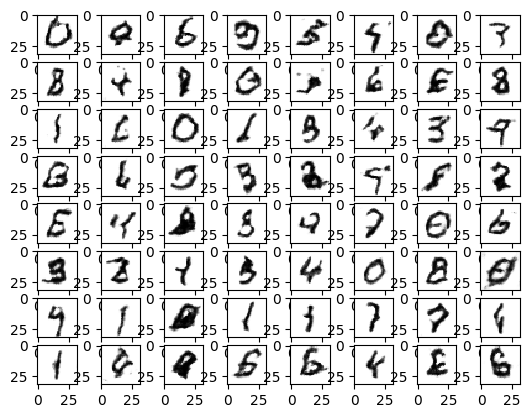

Batch No.: 501 / 938 : GLoss= 6.7937 DLoss= 0.0025


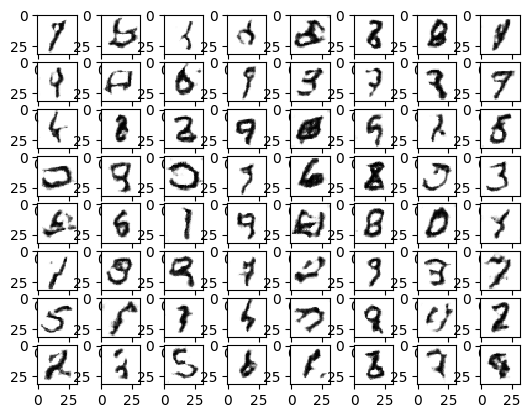

Epoch 7 / 20 :
Batch No.: 1 / 938 : GLoss= 3.573 DLoss= 0.027


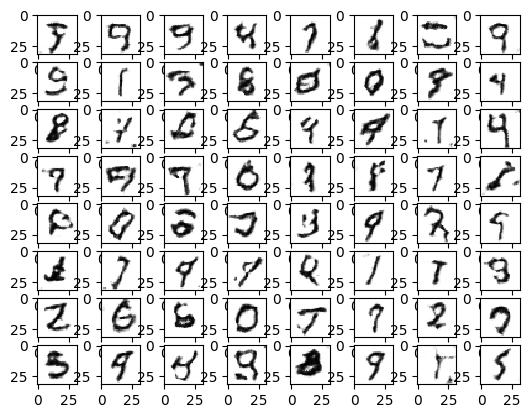

Batch No.: 501 / 938 : GLoss= 8.2103 DLoss= 0.0005


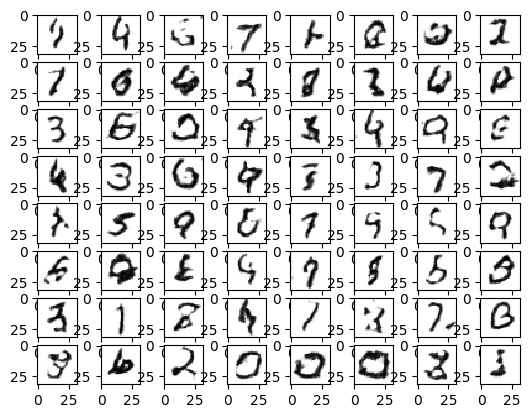

Epoch 8 / 20 :
Batch No.: 1 / 938 : GLoss= 6.2674 DLoss= 0.0017


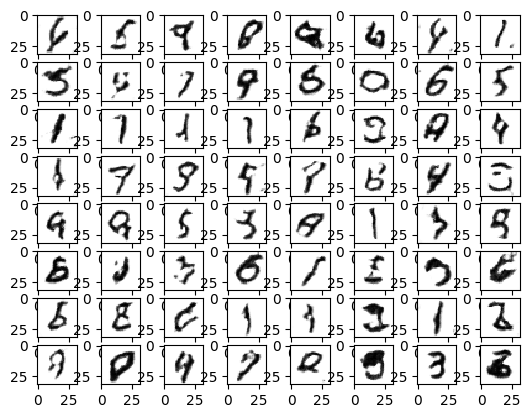

Batch No.: 501 / 938 : GLoss= 1.0728 DLoss= 0.3788


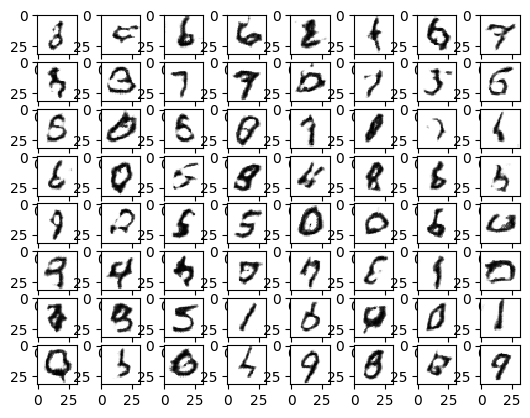

Epoch 9 / 20 :
Batch No.: 1 / 938 : GLoss= 9.1524 DLoss= 0.1


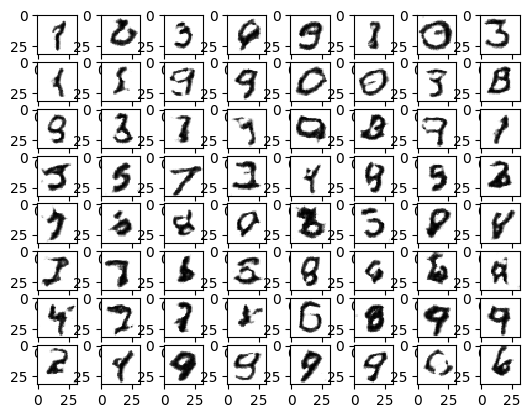

Batch No.: 501 / 938 : GLoss= 7.7382 DLoss= 0.0021


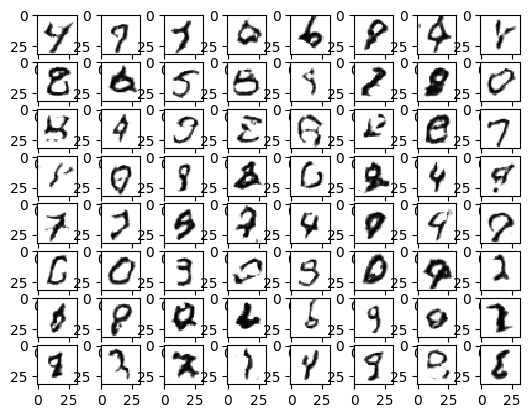

Epoch 10 / 20 :
Batch No.: 1 / 938 : GLoss= 6.2583 DLoss= 0.0021


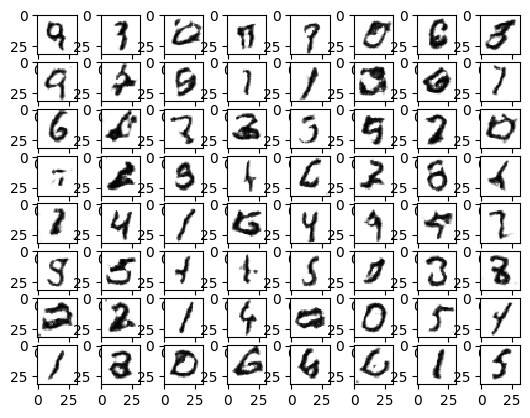

Batch No.: 501 / 938 : GLoss= 8.8395 DLoss= 0.0029


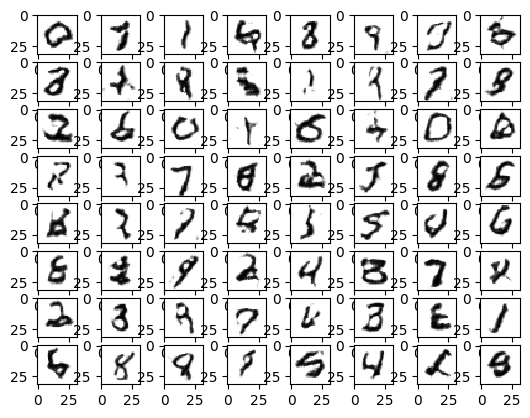

Epoch 11 / 20 :
Batch No.: 1 / 938 : GLoss= 9.9285 DLoss= 0.0028


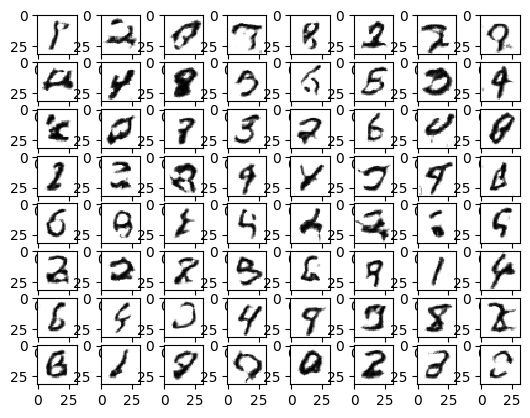

Batch No.: 501 / 938 : GLoss= 6.7047 DLoss= 0.0014


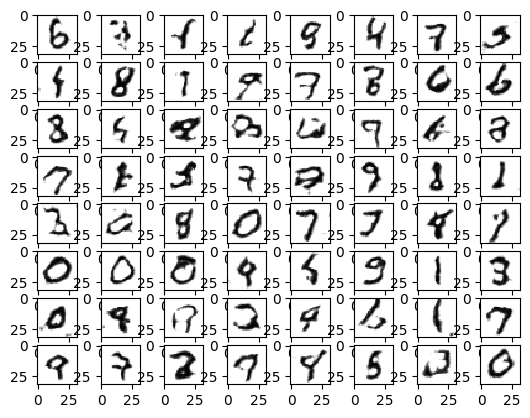

Epoch 12 / 20 :
Batch No.: 1 / 938 : GLoss= 4.7257 DLoss= 0.113


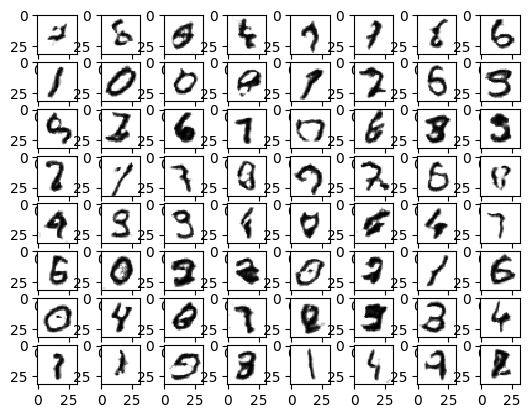

Batch No.: 501 / 938 : GLoss= 11.4511 DLoss= 0.0081


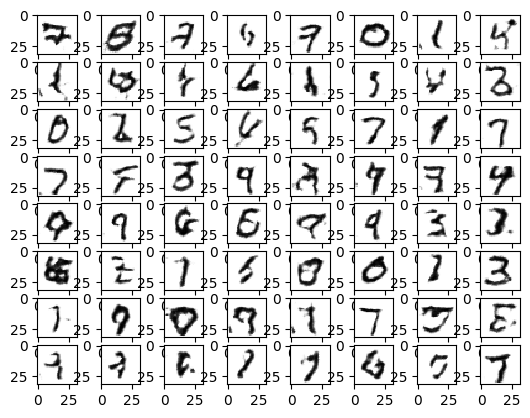

Epoch 13 / 20 :
Batch No.: 1 / 938 : GLoss= 8.894 DLoss= 0.0002


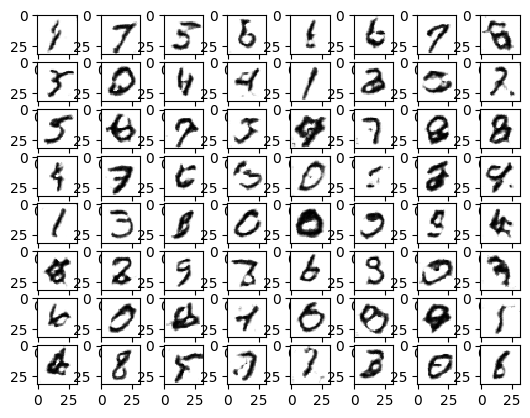

Batch No.: 501 / 938 : GLoss= 10.5005 DLoss= 0.0001


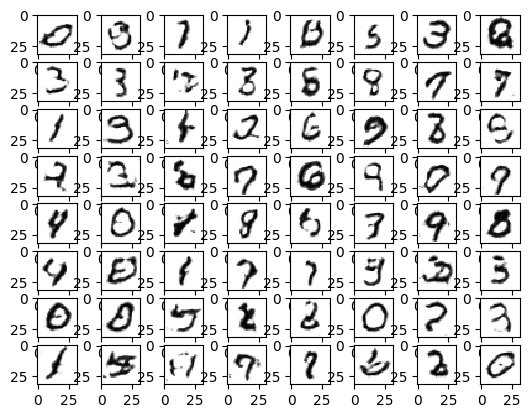

Epoch 14 / 20 :
Batch No.: 1 / 938 : GLoss= 5.7694 DLoss= 0.0035


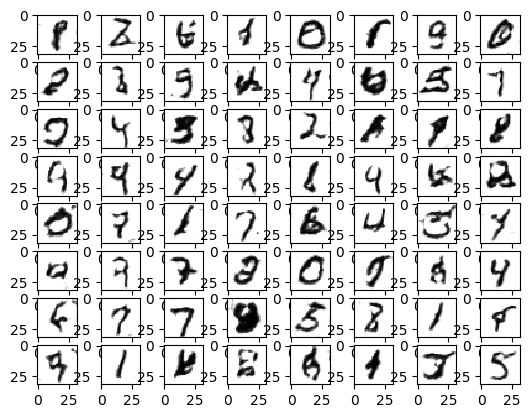

Batch No.: 501 / 938 : GLoss= 10.0858 DLoss= 0.0001


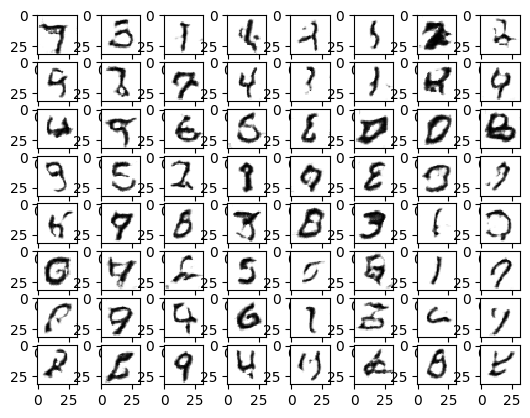

Epoch 15 / 20 :
Batch No.: 1 / 938 : GLoss= 7.8063 DLoss= 0.0004


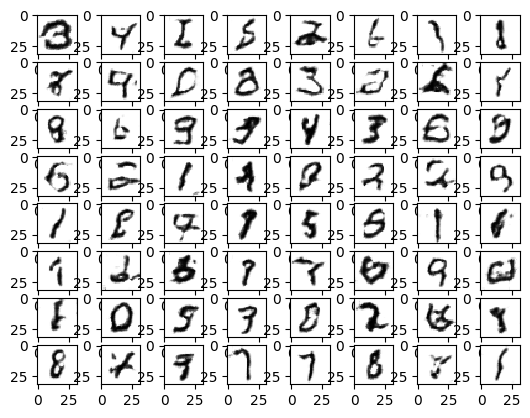

Batch No.: 501 / 938 : GLoss= 10.8963 DLoss= 0.0009


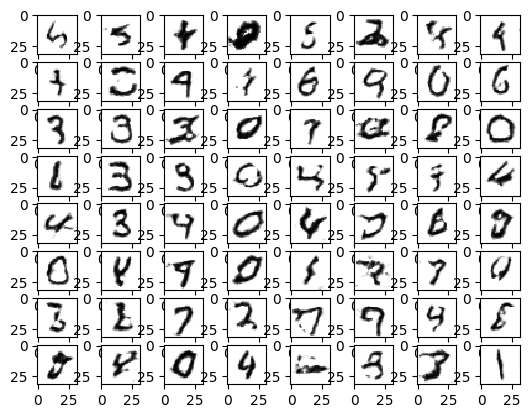

Epoch 16 / 20 :
Batch No.: 1 / 938 : GLoss= 8.9162 DLoss= 0.0006


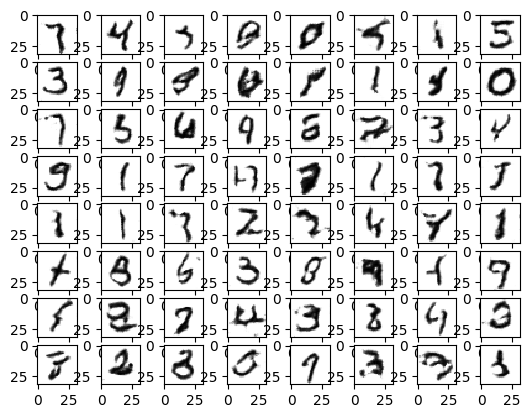

Batch No.: 501 / 938 : GLoss= 5.317 DLoss= 0.0114


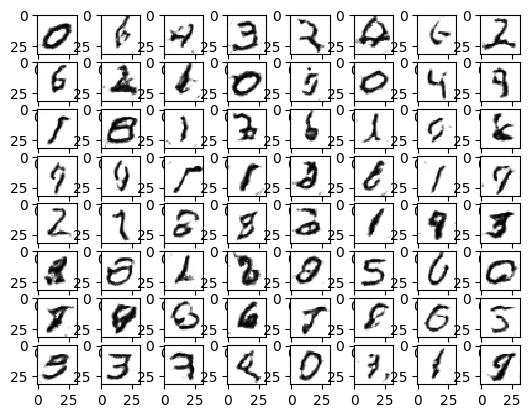

Epoch 17 / 20 :
Batch No.: 1 / 938 : GLoss= 6.8519 DLoss= 0.0015


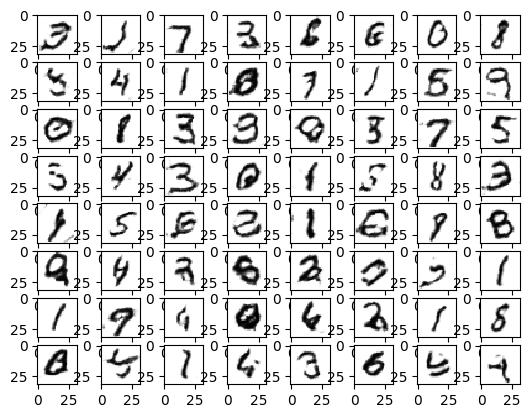

Batch No.: 501 / 938 : GLoss= 8.6188 DLoss= 0.0109


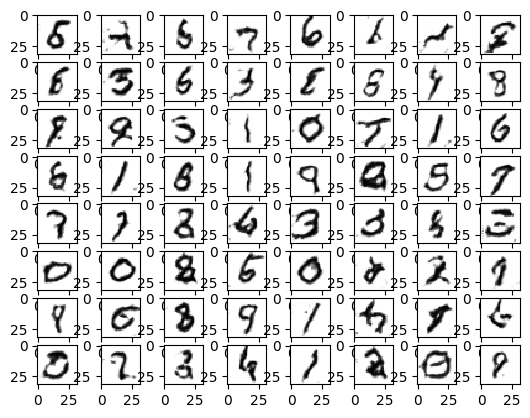

Epoch 18 / 20 :
Batch No.: 1 / 938 : GLoss= 7.3604 DLoss= 0.0006


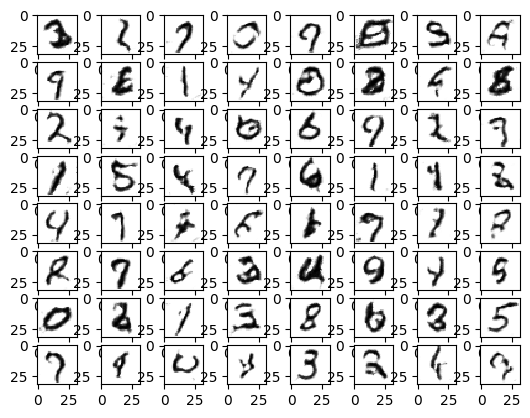

Batch No.: 501 / 938 : GLoss= 9.8583 DLoss= 0.0001


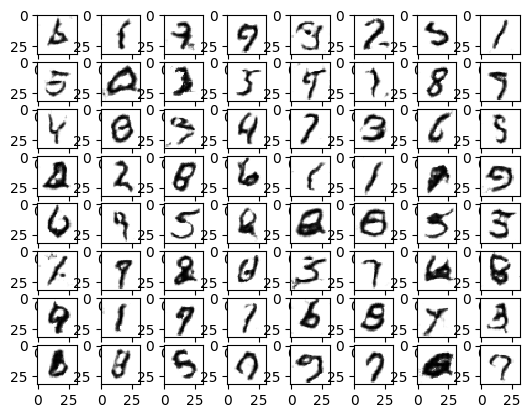

Epoch 19 / 20 :
Batch No.: 1 / 938 : GLoss= 6.4428 DLoss= 0.0022


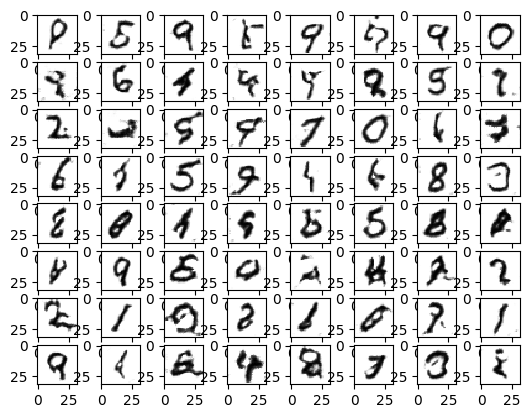

Batch No.: 501 / 938 : GLoss= 9.5277 DLoss= 0.0003


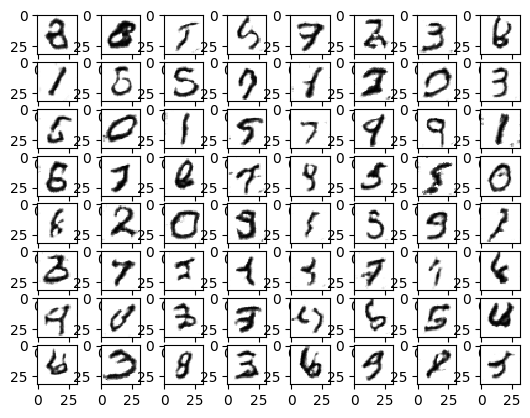

Epoch 20 / 20 :
Batch No.: 1 / 938 : GLoss= 11.768 DLoss= 0.0


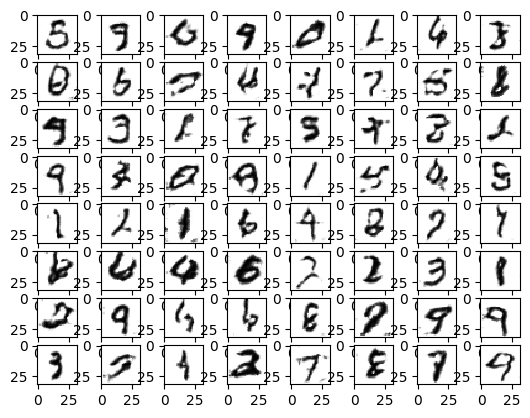

Batch No.: 501 / 938 : GLoss= 13.5693 DLoss= 0.0559


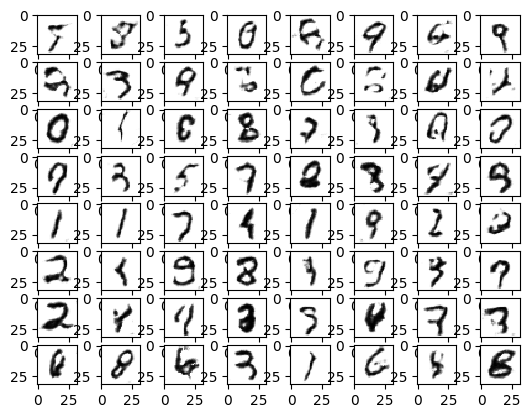

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generated Images")
for e in range(n_epochs):
    print("Epoch",e+1,"/",n_epochs,":")
    train_one_epoch(plt)